# Explainable Boosting Machine (EBM) Model Notebook

This notebook demonstrates how to build an Explainable Boosting Machine (EBM) model using the `interpret` package. Note that the EBM model currently runs on the CPU only.

In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import the EBM classifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Set plot style
sns.set(style='whitegrid')

In [29]:
import pandas as pd

df1 = pd.read_csv('positive.csv', na_values=['NULL'])

df2 = pd.read_csv('negative.csv', na_values=['NULL'])

df = pd.concat([df1, df2], ignore_index=True)

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                              12SL_Codes Source  \
0   HR00008       22,542,1665,533,1666,780,831,1699  PTBXL   
1   HR00077                         22,964,821,1699  PTBXL   
2   HR00085  22,542,1665,531,1666,1682,740,831,1699  PTBXL   
3   HR00103                     23,470,780,831,1699  PTBXL   
4   HR00128                    22,1682,780,831,1699  PTBXL   

                                          Phys_Codes  MI_12SL  MI_Phys  \
0          164865005, 164951009, 39732003, 426783006        1        1   
1                     426783006, 54329005, 713426002        1        1   
2                                          426783006        1        0   
3  164865005, 164951009, 39732003, 427084000, 445...        1        1   
4                                          164934002        1        0   

   TestID  PatientAge  Gender AcquisitionDateTime_DT  ...  STDOWN_V6  \
0       8         NaN     NaN    2020-04-23 07:59:54  ...          0   
1      77         NaN     NaN    2020-

In [30]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = df.fillna(-1000)  # Use an extreme value so it appears in the plot

y = df["MI_Phys"]
X = df.drop(columns=["PatientID", "12SL_Codes", "Phys_Codes", "TestID", "Source", 
                     "Gender", "PatientAge", "AcquisitionDateTime_DT", "MI_Phys"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Save the original algorithm's prediction for test set before dropping it
y_12SL = X_test["MI_12SL"]

# Split data based on MI_12SL classification
X_train_pos = X_train[X_train["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_train_neg = X_train[X_train["MI_12SL"] == 0].drop(columns=["MI_12SL"])
X_test_pos = X_test[X_test["MI_12SL"] == 1].drop(columns=["MI_12SL"])
X_test_neg = X_test[X_test["MI_12SL"] == 0].drop(columns=["MI_12SL"])

# Ensure y labels match the correct samples
y_train_pos = y_train.loc[X_train_pos.index]  # True positives or false positives
y_train_neg = y_train.loc[X_train_neg.index]  # True negatives or false negatives
y_test_pos = y_test.loc[X_test_pos.index]
y_test_neg = y_test.loc[X_test_neg.index]

X_train = X_train.drop(columns=["MI_12SL"])
X_test = X_test.drop(columns=["MI_12SL"])

# Extract MI_12SL predictions for only the positive subset
y_12SL_pos = y_12SL.loc[X_test_pos.index]  # Original classifier's labels
y_12SL_neg = y_12SL.loc[X_test_neg.index]


In [31]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy='constant', fill_value=-1000)
# X_train_pos = imputer.fit_transform(X_train_pos)
# X_test_pos = imputer.transform(X_test_pos)
# X_train_neg = imputer.fit_transform(X_train_neg)
# X_test_neg = imputer.transform(X_test_neg)

In [32]:
ebm = ExplainableBoostingClassifier(
    learning_rate=0.2,
    max_bins=255,
    interactions=2,
    min_samples_leaf=10,
    n_jobs=-2
)
ebm.fit(X_train_pos, y_train_pos)

# Make predictions
y_pred_pos = ebm.predict(X_test_pos)
print("Accuracy:", accuracy_score(y_test_pos, y_pred_pos))
# F1 score
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_test_pos, y_pred_pos))

# Show feature importance
show(ebm.explain_global())

Accuracy: 0.8090478695423461
F1 Score: 0.7665594855305466


<!-- http://127.0.0.1:7001/2193998982288/ -->

In [33]:
import optuna
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

def objective(trial):
    # Define the search space
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_bins = trial.suggest_int("max_bins", 64, 512)
    interactions = trial.suggest_int("interactions", 0, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 100)
    max_leaves = trial.suggest_int("max_leaves", 2, 64)
    
    ebm = ExplainableBoostingClassifier(
        learning_rate=learning_rate,
        max_bins=max_bins,
        interactions=interactions,
        min_samples_leaf=min_samples_leaf,
        max_leaves=max_leaves,
        n_jobs=-2
    )
    
    ebm.fit(X_train_pos, y_train_pos)
    y_pred = ebm.predict(X_test_pos)

    return f1_score(y_test_pos, y_pred)

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2025-04-06 21:04:39,317] A new study created in memory with name: no-name-514c508c-3923-48f0-9fa5-af830aa77217
[I 2025-04-06 21:05:20,231] Trial 0 finished with value: 0.7498349834983499 and parameters: {'learning_rate': 0.07543252012890855, 'max_bins': 408, 'interactions': 2, 'min_samples_leaf': 75, 'max_leaves': 42}. Best is trial 0 with value: 0.7498349834983499.
[I 2025-04-06 21:06:05,251] Trial 1 finished with value: 0.7708998085513721 and parameters: {'learning_rate': 0.1619079161090445, 'max_bins': 372, 'interactions': 4, 'min_samples_leaf': 30, 'max_leaves': 2}. Best is trial 1 with value: 0.7708998085513721.
[I 2025-04-06 21:06:51,985] Trial 2 finished with value: 0.7741522712731925 and parameters: {'learning_rate': 0.026146382254965454, 'max_bins': 499, 'interactions': 1, 'min_samples_leaf': 76, 'max_leaves': 5}. Best is trial 2 with value: 0.7741522712731925.
[I 2025-04-06 21:07:33,916] Trial 3 finished with value: 0.7329357190192181 and parameters: {'learning_rate': 0.09

Best parameters: {'learning_rate': 0.030363409218644333, 'max_bins': 309, 'interactions': 3, 'min_samples_leaf': 100, 'max_leaves': 2}
Best F1 score: 0.777706598334401


In [34]:
best_ebm = ExplainableBoostingClassifier(
    **study.best_params,
    n_jobs=-2
)
best_ebm.fit(X_train_pos, y_train_pos)

from sklearn.metrics import classification_report
print(classification_report(y_test_pos, best_ebm.predict(X_test_pos)))


              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1108
           1       0.79      0.77      0.78       793

    accuracy                           0.82      1901
   macro avg       0.81      0.81      0.81      1901
weighted avg       0.82      0.82      0.82      1901



## Model Evaluation

Test Accuracy: 0.8090478695423461
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1108
           1       0.78      0.75      0.77       793

    accuracy                           0.81      1901
   macro avg       0.80      0.80      0.80      1901
weighted avg       0.81      0.81      0.81      1901



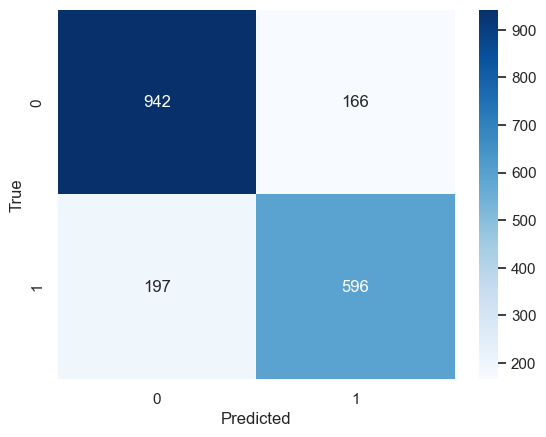

In [35]:
# Make predictions on the test set
y_pred = ebm.predict(X_test_pos)

# Evaluate accuracy
accuracy = accuracy_score(y_test_pos, y_pred)
print('Test Accuracy:', accuracy)

# Display classification report
print(classification_report(y_test_pos, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test_pos, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
# Global explanation
global_explanation = ebm.explain_global()
show(global_explanation)

# Local explanation for the first 5 instances
local_explanation = ebm.explain_local(X_test_pos.iloc[:5], y_test_pos.iloc[:5])
show(local_explanation)

<!-- http://127.0.0.1:7001/2194007601424/ -->

<!-- http://127.0.0.1:7001/2193999564768/ -->

In [37]:
ebm = ExplainableBoostingClassifier(
    learning_rate=0.001,
    max_bins=512,
    interactions=100,
    min_samples_leaf=100,
    early_stopping_rounds=50,
    n_jobs=-2, 
    random_state=42
)

from sklearn.utils.class_weight import compute_sample_weight

# Compute weights based on class distribution
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train_neg)

# Train EBM with sample weights
ebm.fit(X_train_neg, y_train_neg, sample_weight=sample_weights)

#ebm.fit(X_train_neg, y_train_neg)

# Make predictions
y_pred_neg = ebm.predict(X_test_neg)
print("Accuracy:", accuracy_score(y_test_neg, y_pred_neg))
# F1 score
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_test_neg, y_pred_neg))

# Show feature importance
show(ebm.explain_global())

Accuracy: 0.8691292486912925
F1 Score: 0.4341727765380937


<!-- http://127.0.0.1:7001/2197509747248/ -->

In [38]:
import optuna
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

def objective(trial):
    # Define the search space
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_bins = trial.suggest_int("max_bins", 64, 512)
    interactions = trial.suggest_int("interactions", 0, 5)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 100)
    max_leaves = trial.suggest_int("max_leaves", 2, 64)
    
    ebm = ExplainableBoostingClassifier(
        learning_rate=learning_rate,
        max_bins=max_bins,
        interactions=interactions,
        min_samples_leaf=min_samples_leaf,
        max_leaves=max_leaves,
        n_jobs=-2
    )
    
    ebm.fit(X_train_neg, y_train_neg)
    y_pred = ebm.predict(X_test_neg)

    return f1_score(y_test_neg, y_pred)

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best F1 score:", study.best_value)


[I 2025-04-06 21:44:21,476] A new study created in memory with name: no-name-8396679d-f31b-482a-9d04-81e8a3d1d10c
[I 2025-04-06 21:46:00,995] Trial 0 finished with value: 0.33204633204633205 and parameters: {'learning_rate': 0.013679154105825509, 'max_bins': 230, 'interactions': 1, 'min_samples_leaf': 89, 'max_leaves': 50}. Best is trial 0 with value: 0.33204633204633205.
[I 2025-04-06 21:47:38,203] Trial 1 finished with value: 0.3780821917808219 and parameters: {'learning_rate': 0.04719032743881026, 'max_bins': 117, 'interactions': 3, 'min_samples_leaf': 59, 'max_leaves': 24}. Best is trial 1 with value: 0.3780821917808219.
[I 2025-04-06 21:49:02,265] Trial 2 finished with value: 0.3396584440227704 and parameters: {'learning_rate': 0.16789553954331393, 'max_bins': 237, 'interactions': 5, 'min_samples_leaf': 69, 'max_leaves': 50}. Best is trial 1 with value: 0.3780821917808219.
[I 2025-04-06 21:50:25,916] Trial 3 finished with value: 0.3656509695290859 and parameters: {'learning_rate':

Best parameters: {'learning_rate': 0.0467417499027794, 'max_bins': 460, 'interactions': 3, 'min_samples_leaf': 74, 'max_leaves': 2}
Best F1 score: 0.454469507101086


In [39]:
best_ebm = ExplainableBoostingClassifier(
    **study.best_params,
    inner_bags=20,
    n_jobs=-2
)
best_ebm.fit(X_train_neg, y_train_neg)

from sklearn.metrics import classification_report
print(classification_report(y_test_neg, best_ebm.predict(X_test_neg)))


              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12762
           1       0.68      0.32      0.44       801

    accuracy                           0.95     13563
   macro avg       0.82      0.66      0.71     13563
weighted avg       0.94      0.95      0.94     13563



Test Accuracy: 0.8691292486912925
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     12762
           1       0.29      0.85      0.43       801

    accuracy                           0.87     13563
   macro avg       0.64      0.86      0.68     13563
weighted avg       0.95      0.87      0.90     13563



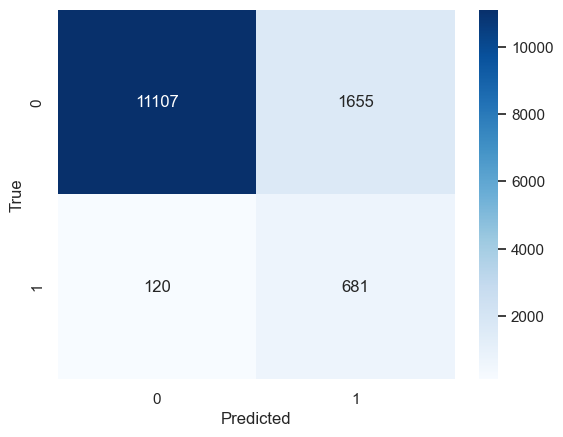

In [40]:
# Make predictions on the test set
y_pred = ebm.predict(X_test_neg)

# Evaluate accuracy
accuracy = accuracy_score(y_test_neg, y_pred)
print('Test Accuracy:', accuracy)

# Display classification report
print(classification_report(y_test_neg, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test_neg, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
# Global explanation
global_explanation = ebm.explain_global()
show(global_explanation)

# Local explanation for the first 5 instances
local_explanation = ebm.explain_local(X_test_neg.iloc[:5], y_test_neg.iloc[:5])
show(local_explanation)

<!-- http://127.0.0.1:7001/2193997716544/ -->

<!-- http://127.0.0.1:7001/2197509606576/ -->